In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# for data load
import os
import pandas as pd
from glob import glob

# for reading and processing images
import imageio
from PIL import Image

# for visualizations
import matplotlib.pyplot as plt

import numpy as np # for using np arrays

# for bulding and running deep learning model
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import precision_score, recall_score, jaccard_score
from scipy.spatial.distance import directed_hausdorff
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from google.colab import files


In [5]:
#upload kaggle token and download dataset
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation
!unzip lgg-mri-segmentation.zip -d /content/dataset

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0
lgg-mri-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  lgg-mri-segmentation.zip
replace /content/dataset/kaggle_3m/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [1]:
def LoadData (path1, path2):
    """
    Looks for relevant filenames in the shared path
    Returns 2 lists for original and masked files respectively

    """
    # Read the images folder like a list

    # Make a list for images and masks filenames
    orig_img = []
    mask_img = []
    for file in path1:
        orig_img.append(file)
    for file in path2:
        mask_img.append(file)

    # Sort the lists to get both of them in same order (the dataset has exactly the same name for images and corresponding masks)
    orig_img.sort()
    mask_img.sort()

    return orig_img, mask_img



In [3]:
def PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2):
    """
    Processes the images and mask present in the shared list and path
    Returns a NumPy dataset with images as 3-D arrays of desired size
    Please note the masks in this dataset have only one channel
    """
    # Pull the relevant dimensions for image and mask
    m = len(img)                     # number of images
    i_h,i_w,i_c = target_shape_img   # pull height, width, and channels of image
    m_h,m_w,m_c = target_shape_mask  # pull height, width, and channels of mask

    # Define X and Y as number of images along with shape of one image
    X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.float32)
    i = 0
    # Resize images and masks
    for file in img:
        # convert image into an array of desired shape (3 channels)
        index = img.index(file)
        path = os.path.join(path1[i], file)
        single_img = Image.open(path).convert('RGB')
        single_img = single_img.resize((i_h,i_w))
        single_img = np.reshape(single_img,(i_h,i_w,i_c))
        single_img = single_img/255.
        X[index] = single_img

        # convert mask into an array of desired shape (1 channel)
        single_mask_ind = mask[index]
        path = os.path.join(path2[i], single_mask_ind)
        single_mask = Image.open(path)
        single_mask = single_mask.resize((m_h, m_w))
        single_mask = np.array(single_mask,dtype=np.float32)
        # Ensure classes start from 0 (if necessary)
        single_mask[single_mask == 255] = 0  # Convert 255 to background (0)
        single_mask[single_mask > 1] = 1  # Ensure only two classes: 0 (background) and 1 (tumor)

        # Reshape and store in y
        single_mask = np.reshape(single_mask, (m_h, m_w, m_c))
        y[index] = single_mask
        i += 1
    return X, y



In [4]:
def dice_coefficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-7) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1e-7)

# IoU (Jaccard Index)
def iou(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + 1e-7) / (union + 1e-7)

In [5]:
import numpy as np

def compute_metrics(y_true, y_pred):
    y_pred_bin = (y_pred > 0.5).astype(np.uint8)  # Convert to binary mask

    dice = dice_coefficient(y_true, y_pred_bin).numpy()
    iou_score = iou(y_true, y_pred_bin).numpy()

    precision = precision_score(y_true.flatten(), y_pred_bin.flatten(), zero_division=1)
    recall = recall_score(y_true.flatten(), y_pred_bin.flatten(), zero_division=1)

    hausdorff_dist = directed_hausdorff(y_true.squeeze(), y_pred_bin.squeeze())[0]

    return {
        'Dice Coefficient': dice,
        'IoU': iou_score,
        'Precision': precision,
        'Recall': recall,
        'Hausdorff Distance': hausdorff_dist
    }


In [6]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning.
    Dropout can be added for regularization to prevent overfitting.
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow
    # Proper initialization prevents from the problem of exploding and vanishing gradients
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)

    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions
    skip_connection = conv

    return next_layer, skip_connection

In [7]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)

    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters,
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

In [8]:
def UNetCompiled(input_size=(128, 128, 3), n_filters=32, n_classes=1):
   """
   Combine both encoder and decoder blocks according to the U-Net research paper
   Return the model as output
   """
   inputs = Input(input_size)
   # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
   # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image
   cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
   cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
   cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
   cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
   cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

   # Decoder includes multiple mini blocks with decreasing number of filters
   # Observe the skip connections from the encoder are given as input to the decoder
   # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
   ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
   ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
   ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
   ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

   # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
   # Followed by a 1x1 Conv layer to get the image to the desired size.
   # Observe the number of channels will be equal to number of output classes
   conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
   conv10 = Conv2D(n_classes, 1, padding='same', activation= 'sigmoid')(conv9)
   # Define the model
   model = tf.keras.Model(inputs=inputs, outputs=conv10)

   return model

In [9]:
def get_file_row(path):
    """Produces ID of a patient, image and mask filenames from a particular path"""
    path_no_ext, ext = os.path.splitext(path)
    filename = os.path.basename(path)

    patient_id = '_'.join(filename.split('_')[:3]) # Patient ID in the csv file consists of 3 first filename segments

    return [patient_id, path, f'{path_no_ext}_mask{ext}']

files_dir = '/content/dataset/lgg-mri-segmentation/kaggle_3m'
file_paths = glob(f'{files_dir}/*/*[0-9].tif')
filenames_df = pd.DataFrame((get_file_row(filename) for filename in file_paths), columns=['Patient', 'image_filename', 'mask_filename'])

filenames_df


,Patient,image_filename,mask_filename
0,TCGA_CS_6669,/content/dataset/lgg-mri-segmentation/kaggle_3...,/content/dataset/lgg-mri-segmentation/kaggle_3...
1,TCGA_CS_6669,/content/dataset/lgg-mri-segmentation/kaggle_3...,/content/dataset/lgg-mri-segmentation/kaggle_3...
2,TCGA_CS_6669,/content/dataset/lgg-mri-segmentation/kaggle_3...,/content/dataset/lgg-mri-segmentation/kaggle_3...
3,TCGA_CS_6669,/content/dataset/lgg-mri-segmentation/kaggle_3...,/content/dataset/lgg-mri-segmentation/kaggle_3...
4,TCGA_CS_6669,/content/dataset/lgg-mri-segmentation/kaggle_3...,/content/dataset/lgg-mri-segmentation/kaggle_3...
...,...,...,...
3924,TCGA_HT_7475,/content/dataset/lgg-mri-segmentation/kaggle_3...,/content/dataset/lgg-mri-segmentation/kaggle_3...
3925,TCGA_HT_7475,/content/dataset/lgg-mri-segmentation/kaggle_3...,/content/dataset/lgg-mri-segmentation/kaggle_3...
3926,TCGA_HT_7475,/content/dataset/lgg-mri-segmentation/kaggle_3...,/content/dataset/lgg-mri-segmentation/kaggle_3...
3927,TCGA_HT_7475,/content/dataset/lgg-mri-segmentation/kaggle_3...,/content/dataset/lgg-mri-segmentation/kaggle_3...


<ipython-input-10-1d9abb59f19a>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_view  = imageio.imread(path1[i])
<ipython-input-10-1d9abb59f19a>:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask_view = imageio.imread(path2[i])


(256, 256, 3)
(256, 256)


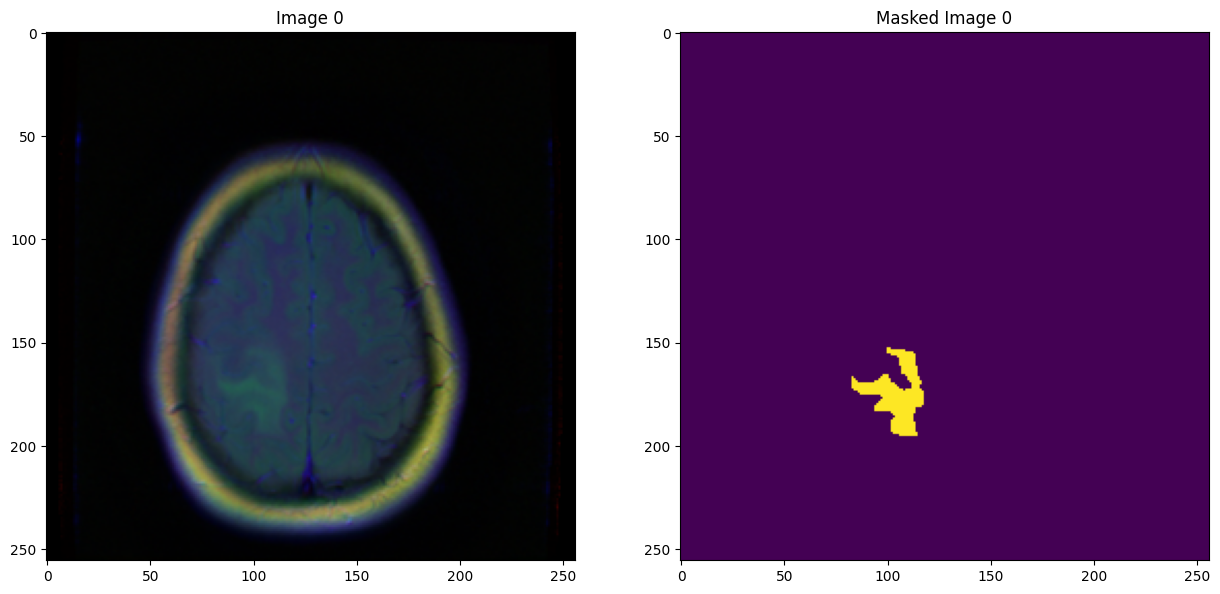

In [10]:
""" Load Train Set and view some examples """
# Call the apt function
path1 = filenames_df["image_filename"].tolist()
path2 = filenames_df["mask_filename"].tolist()
img, mask = LoadData (path1, path2)


# View an example of image and corresponding mask
show_images = 1
for i in range(show_images):
    img_view  = imageio.imread(path1[i])
    mask_view = imageio.imread(path2[i])
    print(img_view.shape)
    print(mask_view.shape)
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(img_view)
    arr[0].set_title('Image '+ str(i))
    arr[1].imshow(mask_view)
    arr[1].set_title('Masked Image '+ str(i))

X Shape: (3929, 128, 128, 3)
Y shape: (3929, 128, 128, 1)
[0. 1.]


Text(0.5, 1.0, 'Processed Masked Image')

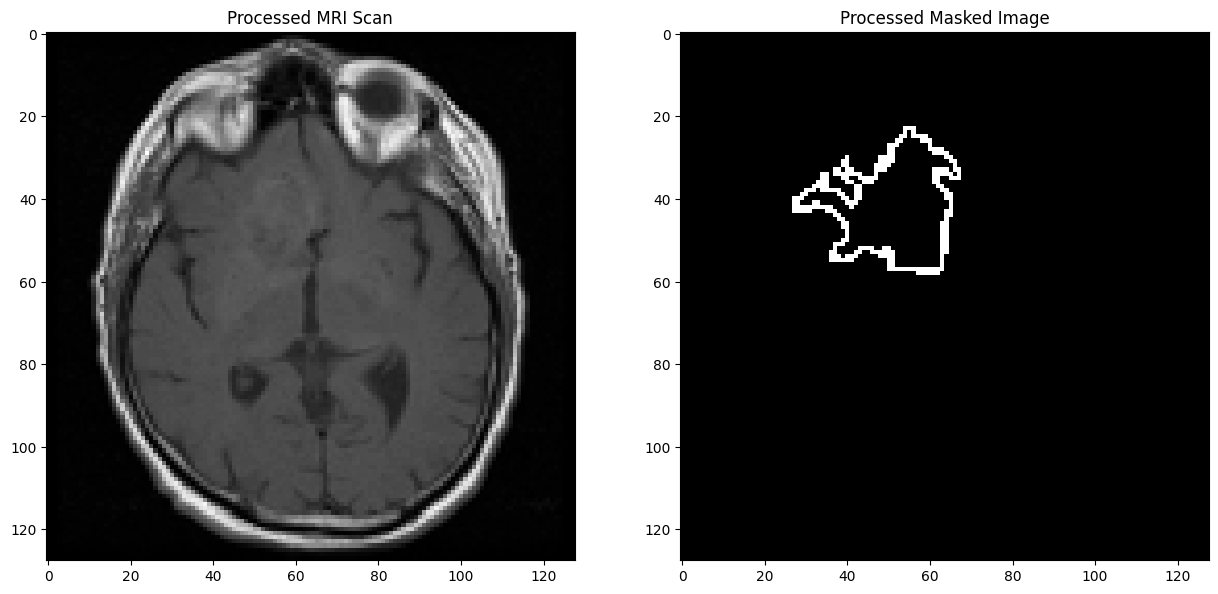

In [11]:
# Define the desired shape
target_shape_img = [128, 128, 3]
target_shape_mask = [128, 128, 1]

# Process data using apt helper function
X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2)

# QC the shape of output and classes in output dataset
print("X Shape:", X.shape)
print("Y shape:", y.shape)
# There are 2 classes : background, tumor
print(np.unique(y))

# Visualize the output
image_index = 3
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(X[image_index, :, :, 0], cmap='gray')  # Show MRI image in grayscale
arr[0].set_title('Processed MRI Scan')

arr[1].imshow(y[image_index, :, :, 0], cmap='gray')  # Show mask in grayscale
arr[1].set_title('Processed Masked Image')


In [12]:
# Use scikit-learn's function to split the dataset
# Here, I have used 20% data as test/valid set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)



In [13]:
# Call the helper function for defining the layers for the model, given the input image size
unet = UNetCompiled(input_size=(128,128,3), n_filters=32, n_classes=1)

In [14]:
# There are multiple optimizers, loss functions and metrics that can be used to compile multi-class segmentation models
# Ideally, try different options to get the best accuracy
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with Early Stopping

unet.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy', dice_coefficient, iou])

In [21]:
# Run the model in a mini-batch fashion and compute the progress for each epoch
results = unet.fit(X_train, y_train, batch_size=128, epochs=30 , validation_data=(X_valid, y_valid))

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1187s 47s/step - accuracy: 0.9963 - dice_coefficient: 0.0537 - iou: 0.0276 - loss: 0.0166 - val_accuracy: 0.9963 - val_dice_coefficient: 0.0213 - val_iou: 0.0108 - val_loss: 0.0732
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1221s 48s/step - accuracy: 0.9964 - dice_coefficient: 0.0841 - iou: 0.0439 - loss: 0.0156 - val_accuracy: 0.9963 - val_dice_coefficient: 0.0212 - val_iou: 0.0107 - val_loss: 0.0570
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1202s 47s/step - accuracy: 0.9963 - dice_coefficient: 0.0928 - iou: 0.0487 - loss: 0.0148 - val_accuracy: 0.9963 - val_dice_coefficient: 0.0200 - val_iou: 0.0101 - val_loss: 0.0313
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1209s 46s/step - accuracy: 0.9963 - dice_coefficient: 0.1112 - iou: 0.0589 - loss: 0.0142 - val_accuracy: 0.9963 - val_dice_coefficient: 0.0248 - val_iou: 0.0126 - val_loss: 0.0274
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1163s 47s/step - accuracy: 0.9962 - dice_coefficient: 0.1284 - iou: 0.0686 - loss: 0.0

In [22]:
print(results.history['accuracy'])

[0.9963010549545288, 0.9963010549545288, 0.9963010549545288, 0.9963007569313049, 0.9963011741638184, 0.9963010549545288, 0.9963011741638184, 0.996300995349884, 0.996300995349884, 0.9963008165359497, 0.9963010549545288, 0.996300995349884, 0.9963012337684631, 0.9963011741638184, 0.9963010549545288, 0.9963010549545288, 0.9963015913963318, 0.996301531791687, 0.9963017106056213, 0.9963024854660034, 0.9963049292564392, 0.9963078498840332, 0.996310293674469, 0.9963138103485107, 0.9963209629058838, 0.9963243007659912, 0.9963284134864807, 0.9963288307189941, 0.9963324666023254, 0.9963460564613342]


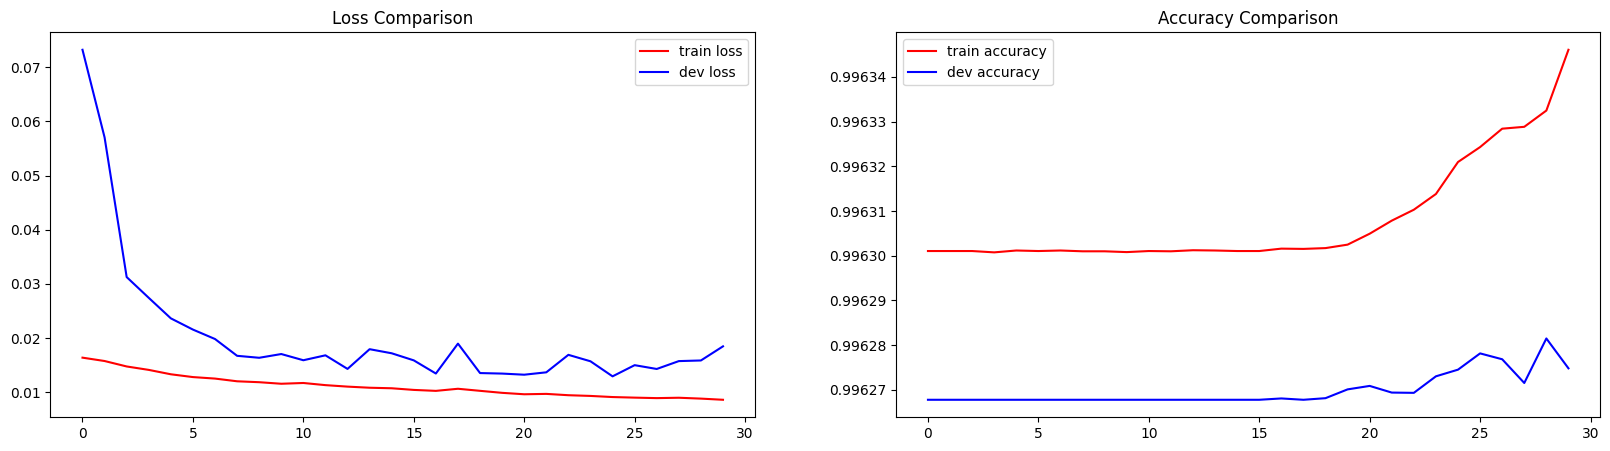

In [23]:
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'dev loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'dev accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()


In [24]:
unet.evaluate(X_valid, y_valid)

25/25 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.9962 - dice_coefficient: 0.2090 - iou: 0.1173 - loss: 0.0195


[0.01846276968717575,
 0.9962748289108276,
 0.20880605280399323,
 0.1169600784778595]

In [25]:
# Results of Validation Dataset
def VisualizeResults(index):
    img = X_valid[index]
    img = img[np.newaxis, ...]
    pred_y = unet.predict(img)
    pred_mask = (pred_y[0] > 0.5).astype(np.float32)  # Threshold at 0.5
    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(X_valid[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(y_valid[index, :, :, 0], cmap='gray')  # Display true mask
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(pred_mask[:, :, 0], cmap='gray')  # Display thresholded prediction
    arr[2].set_title('Predicted Masked Image ')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


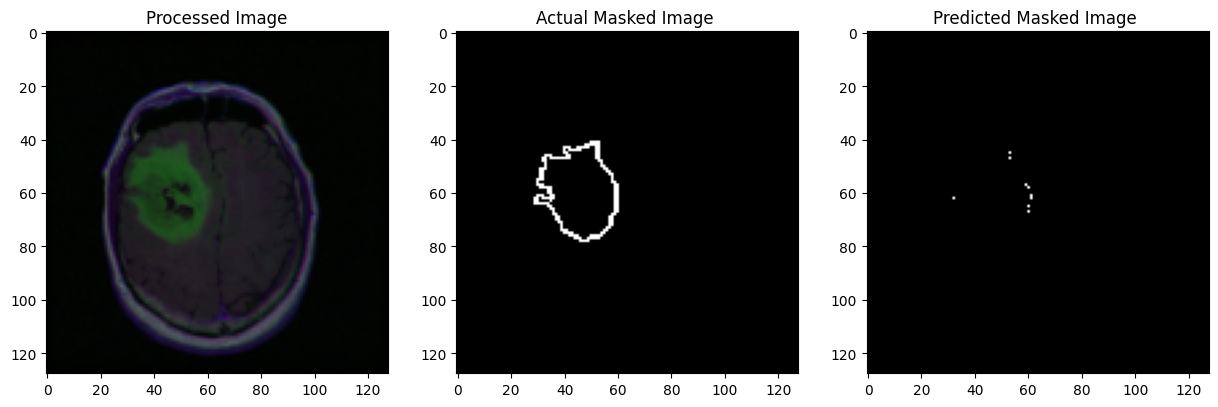

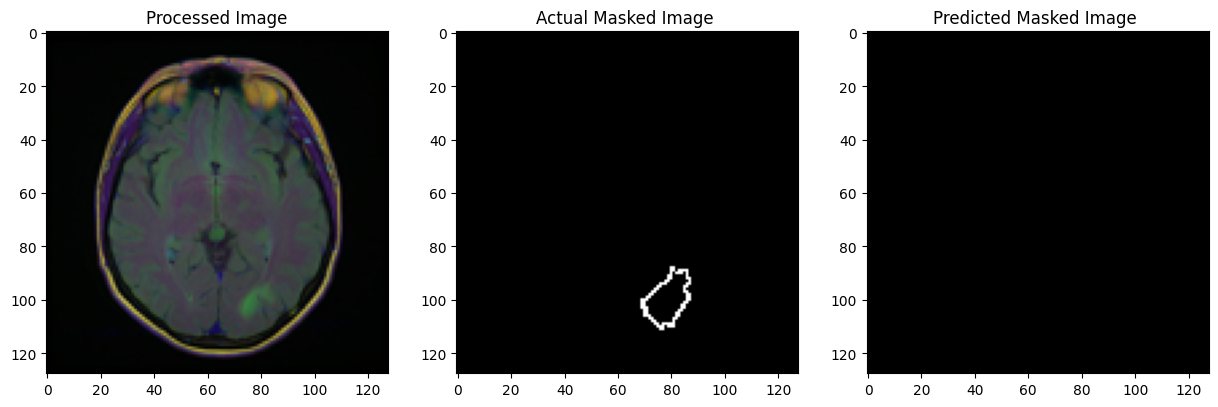

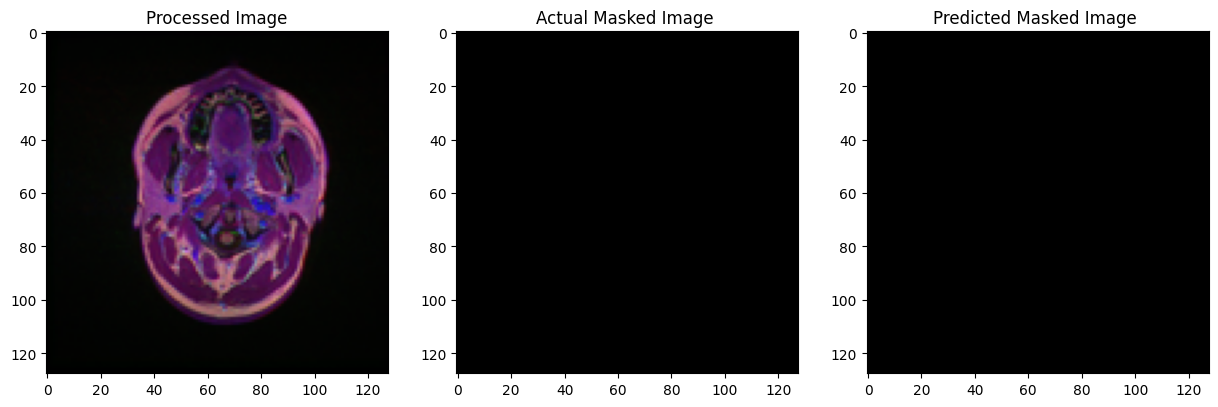

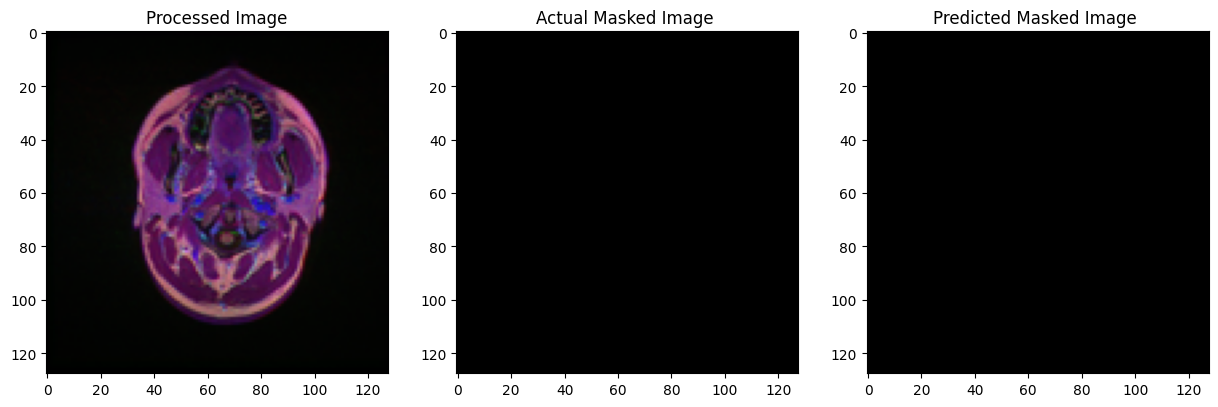

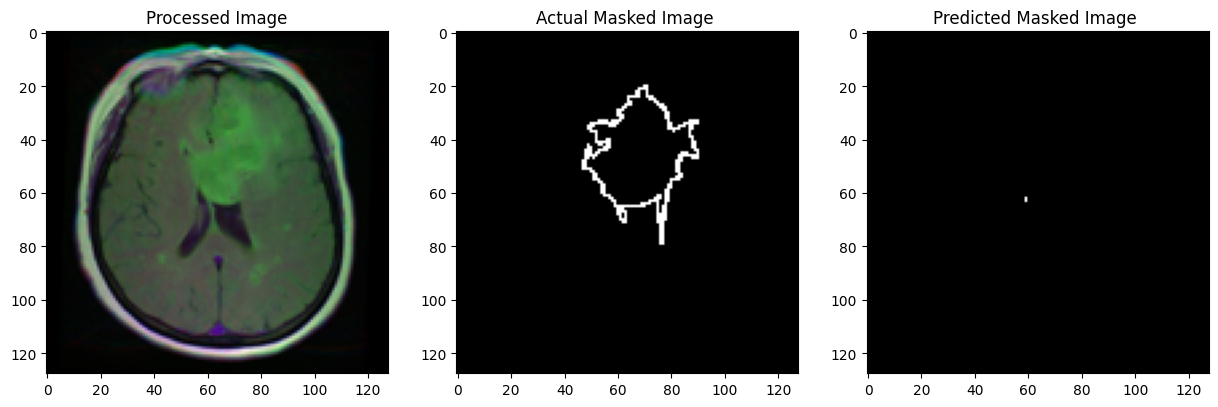

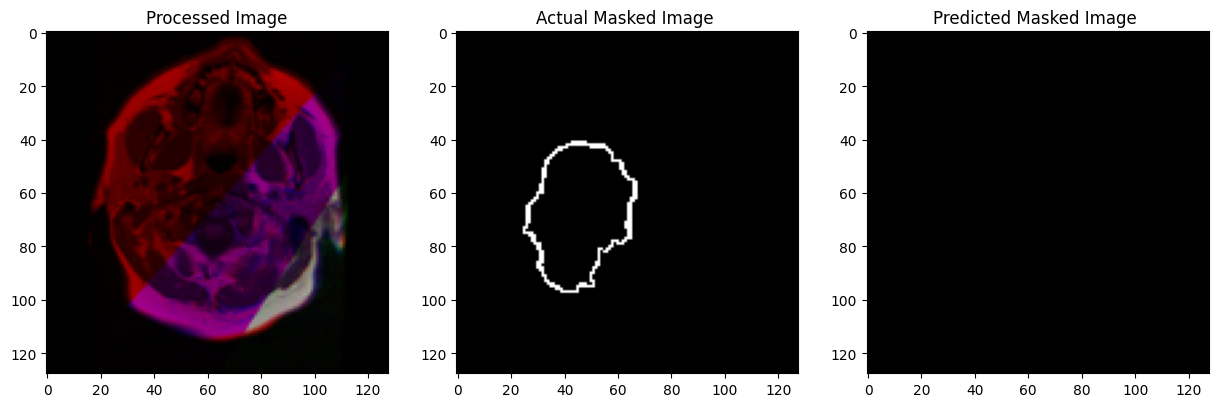

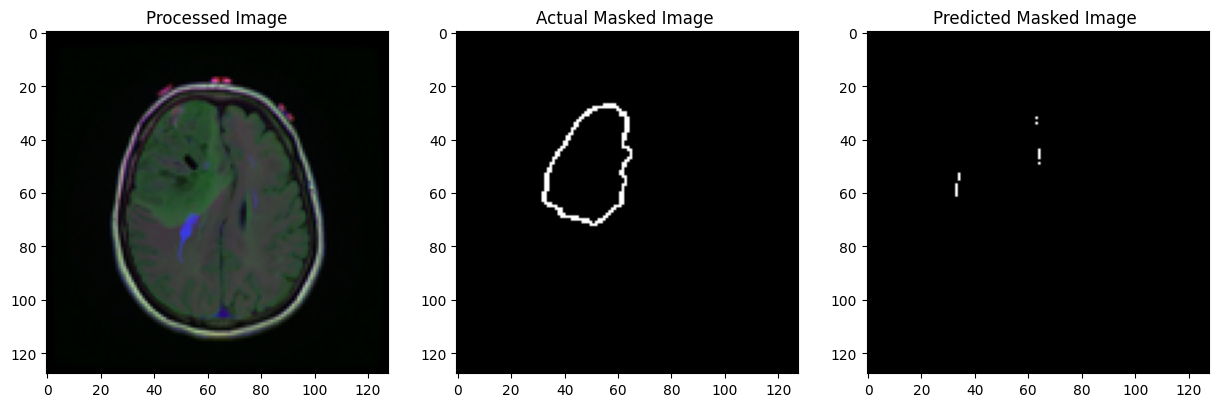

In [26]:
# Add any index to contrast the predicted mask with actual mask
index = 1
VisualizeResults(index)
index = 20
VisualizeResults(index)
index = 15
VisualizeResults(index)
VisualizeResults(index)
index = 13
VisualizeResults(index)
index = 34
VisualizeResults(index)
index = 44
VisualizeResults(index)